## Grad Cam

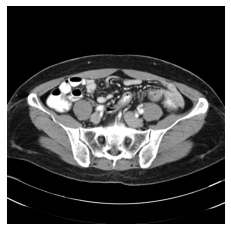

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import pandas as pd

from utils.dataset import BodyDataset
from utils.dcmUtil import tensorShow

test_ds = BodyDataset(pd.read_csv('../../classifier/train_data/35_350_test.csv'), standardization = '30')
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

x, y = next(iter(test_loader))
tensorShow(x[0])

In [7]:
# resnet18
model = models.resnet18()
in_feature = model.fc.in_features
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=in_feature, out_features=2, bias=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load('../../classifier/35_350_result/loss_0.32_resnet18_v6.pt'))

model.to(device)
model.eval()
print('model loaded')

model loaded


In [8]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_loader))
    y = y.ravel()
    x = x.to(device)

    y_pred = model(x).cpu()
    y_pred = torch.softmax(y_pred, 1)

    print('True:', y)
    print('Pred:', y_pred.argmax(1))

True: tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0])
Pred: tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0])


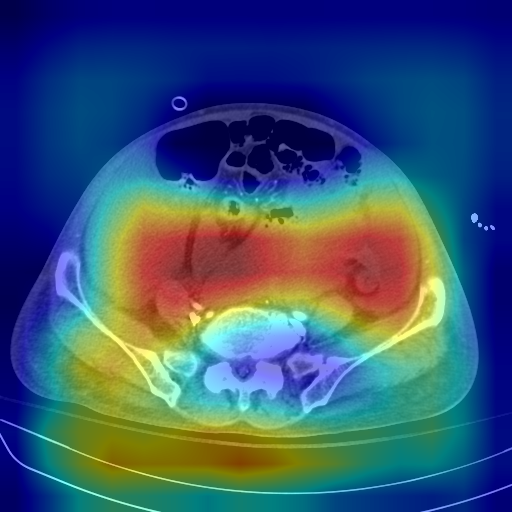

In [9]:
# Resnet grad cam
num = 2
target_layers = [model.layer4[-1]]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
input_tensors = x

image = x[num].permute(1,2,0).cpu().numpy()
image = (image - image.min()) / (image.max() - image.min())
result = cam(input_tensor=input_tensors[num].unsqueeze(0)).squeeze()
cam_image=show_cam_on_image(image, result, use_rgb=True)
Image.fromarray(cam_image)

## Confusion Matrix

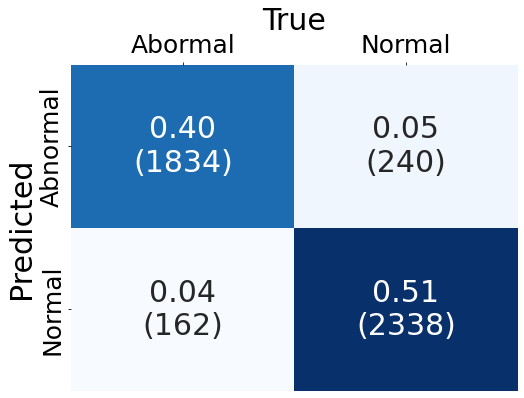

Recall:  0.919
Precision:  0.884
Specificity:  0.907
Acc:  0.912


In [27]:
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_preds = []
y_reals = []

for x, y in tqdm(test_loader):
    y = y.ravel()
    
    y_pred = model(x.cuda())
    y_pred = torch.where(torch.softmax(y_pred, 1) > 0.5)[1].cpu().numpy()
    
    y_preds.extend(y_pred)
    y_reals.extend(y.cpu().numpy())

cm = confusion_matrix(y_reals, y_preds)
cm = np.flip(cm).transpose()

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2f}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_percentages, group_counts)]
labels = np.asarray(labels).reshape(2,2)


fig, ax = plt.subplots(figsize=(8,6))
# ax.set_title('Confusion Matrix', fontsize=20)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 30})
ax.set_ylabel('Predicted', fontsize=30)
ax.set_xlabel('True', fontsize=30)
ax.xaxis.set_label_position('top')
ax.set_xticks([0.5,1.5],['Abormal', 'Normal'], fontsize=25)
ax.set_yticks([0.5,1.5],['Abnormal', 'Normal'], fontsize=25)
ax.xaxis.tick_top()
plt.show()

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

acc = (TP + TN) / (TP + FP + TN + FN) 
recall = TP / (TP + FN)
precision = TP / (TP+FP)
specificity = TN / (TN+FP)

print(f'Recall: {recall : .3f}')
print(f'Precision: {precision : .3f}')
print(f'Specificity: {specificity : .3f}')
print(f'Acc: {acc : .3f}')

### ROC curve & AUC

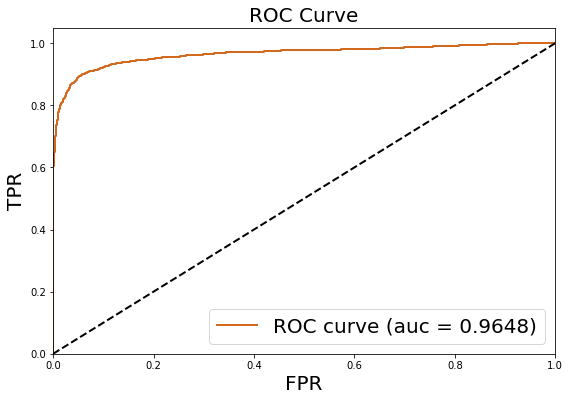

In [18]:
from sklearn.metrics import roc_curve, auc

y_preds = np.zeros((0,2))
y_reals = np.zeros((0,2))

with torch.no_grad():
    for x, y in tqdm(test_loader):
        y = torch.nn.functional.one_hot(y.ravel())
        y_pred = model(x.cuda())
        y_pred = torch.softmax(y_pred, 1)
        y_preds = np.append(y_preds, y_pred.cpu().numpy(), axis=0 )
        y_reals = np.append(y_reals, y.cpu().numpy(), axis=0 )

n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_reals[:, i], y_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_reals.ravel(), y_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(9,6))
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="chocolate",
    lw=lw,
    label="ROC curve (auc = %0.4f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.title("ROC Curve", fontsize=20)
plt.legend(loc="lower right", fontsize=20)
plt.show()